In [ ]:
# Step 0: Install & imports
!pip install -q pandas numpy scikit-learn joblib matplotlib seaborn openpyxl

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
from google.colab import files
uploaded = files.upload()         # choose sim_dataset_with_phone_features.xlsx
DATA_PATH = list(uploaded.keys())[0]
print("Loaded file:", DATA_PATH)

df = pd.read_excel(DATA_PATH)
print("Rows, cols:", df.shape)
df.head()


Saving sim_dataset_with_phone_features.xlsx to sim_dataset_with_phone_features.xlsx
Loaded file: sim_dataset_with_phone_features.xlsx
Rows, cols: (10000, 30)


,sim_id,customer_id,operator,registered_company,status,call_count_outgoing,call_count_incoming,avg_call_duration,sms_count_sent,sms_count_received,...,current_location,avg_daily_usage,usage_variance,sudden_spike_flag,isOutOfZone,isAnomaly,Phone no,is_company_number,carrier_code,is_vip_number
0,VI1001,CUST0001,VI,Vodafone Idea Ltd,Active,1,47,3.48,7,4,...,Pune,1251.510000,1728.249128,1,0,0,8484215378,0,84,0
1,VI1002,CUST0002,VI,Vodafone Idea Ltd,Active,45,41,7.31,13,7,...,Chennai,793.193333,1047.138167,1,0,1,9552574563,1,95,0
2,JIO1003,CUST0003,Jio,Reliance Jio Ltd,Active,24,6,4.23,11,19,...,Pune,473.126667,626.675742,1,1,1,8352130729,1,83,0
3,VI1004,CUST0004,VI,Vodafone Idea Ltd,Active,45,4,1.41,7,9,...,Chennai,1663.950000,2307.258049,1,0,1,7117733841,1,71,0
4,VI1005,CUST0005,VI,Vodafone Idea Ltd,Deactivated,41,4,6.48,5,17,...,Mumbai,1242.060000,1709.187735,1,1,1,7870244910,0,78,0


In [ ]:
# Step 2: quick inspection
print(df.columns.tolist())
display(df.dtypes)
display(df.isna().sum().sort_values(ascending=False).head(25))
display(df.describe(include='all').T)


['sim_id', 'customer_id', 'operator', 'registered_company', 'status', 'call_count_outgoing', 'call_count_incoming', 'avg_call_duration', 'sms_count_sent', 'sms_count_received', 'data_usage_mb', 'recharge_amount', 'recharge_frequency', 'unique_location_count', 'roaming_flag', 'device_change_count', 'international_calls_count', 'premium_calls_count', 'sim_swap_attempts', 'registered_location', 'current_location', 'avg_daily_usage', 'usage_variance', 'sudden_spike_flag', 'isOutOfZone', 'isAnomaly', 'Phone no', 'is_company_number', 'carrier_code', 'is_vip_number']


,0
sim_id,object
customer_id,object
operator,object
registered_company,object
status,object
call_count_outgoing,int64
call_count_incoming,int64
avg_call_duration,float64
sms_count_sent,int64
sms_count_received,int64


,0
sim_id,0
customer_id,0
operator,0
registered_company,0
status,0
call_count_outgoing,0
call_count_incoming,0
avg_call_duration,0
sms_count_sent,0
sms_count_received,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sim_id,10000,2000,JIO1726,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,10000,2000,CUST0528,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operator,10000,3,Jio,3367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registered_company,10000,3,Reliance Jio Ltd,3347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status,10000,3,Suspended,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
call_count_outgoing,10000.0,NaN,NaN,NaN,25.9764,13.423385,0.0,16.0,25.0,35.0,78.0
call_count_incoming,10000.0,NaN,NaN,NaN,25.7264,13.51329,0.0,16.0,25.0,35.0,80.0
avg_call_duration,10000.0,NaN,NaN,NaN,5.565402,2.475002,0.004733,3.733715,5.489047,7.333946,14.639407
sms_count_sent,10000.0,NaN,NaN,NaN,10.0549,5.440482,0.0,6.0,10.0,14.0,30.0
sms_count_received,10000.0,NaN,NaN,NaN,9.9185,5.417822,0.0,6.0,9.0,14.0,32.0


In [ ]:
# Step 3: ensure phone features exist
PREF_LEN = 4   # choose 3/4/5 depending on granularity

# detect phone column
phone_candidates = [c for c in df.columns if 'phone' in c.lower() or 'mobile' in c.lower()]
phone_col = phone_candidates[0] if phone_candidates else None
print("Detected phone column:", phone_col)

if phone_col and 'phone_prefix' not in df.columns:
    df['phone_prefix'] = df[phone_col].astype(str).str[:PREF_LEN].fillna('UNK')
    print("Created phone_prefix")

if 'is_company_number' not in df.columns:
    if 'registered_company' in df.columns:
        df['is_company_number'] = df['registered_company'].notna().astype(int)
        print("Created is_company_number from registered_company")
    else:
        df['is_company_number'] = 0
        print("Set is_company_number = 0 (default)")
display(df[['phone_prefix','is_company_number']].head())


Detected phone column: Phone no
Created phone_prefix


,phone_prefix,is_company_number
0,8484,0
1,9552,1
2,8352,1
3,7117,1
4,7870,0


In [ ]:
# Step 4: feature selection (edit names to match your df)
suggested_numeric = [
    "call_count_outgoing", "call_count_incoming", "avg_call_duration",
    "sms_count_sent", "sms_count_received", "data_usage",
    "avg_daily_usage", "usage_variance"
]
suggested_categorical = ["is_company_number", "phone_prefix", "status", "registered_location", "current_location"]

num_features = [c for c in suggested_numeric if c in df.columns]
cat_features = [c for c in suggested_categorical if c in df.columns]

print("Numeric ->", num_features)
print("Categorical ->", cat_features)

X_raw = df[num_features + cat_features].copy()
label_col = 'isAnomaly' if 'isAnomaly' in df.columns else None
y = df[label_col] if label_col else None
print("Label column:", label_col)


Numeric -> ['call_count_outgoing', 'call_count_incoming', 'avg_call_duration', 'sms_count_sent', 'sms_count_received', 'avg_daily_usage', 'usage_variance']
Categorical -> ['is_company_number', 'phone_prefix', 'status', 'registered_location', 'current_location']
Label column: isAnomaly


In [ ]:
# Step 5: preprocessing setup
HIGH_CARD = 40
freq_encode_cols = [c for c in cat_features if X_raw[c].nunique() > HIGH_CARD]
onehot_cols = [c for c in cat_features if c not in freq_encode_cols]

# Create freq-encoded numeric columns
for c in freq_encode_cols:
    freq = X_raw[c].value_counts(normalize=True)
    X_raw[c + "_freq"] = X_raw[c].map(freq).fillna(0.0)
    onehot_cols = [col for col in onehot_cols if col != c]

# Append the freq encoded columns to num_features after creating them in X_raw
for c in freq_encode_cols:
    if c + "_freq" not in num_features:
        num_features.append(c + "_freq")


cat_for_onehot = onehot_cols

print("Freq-encoded:", freq_encode_cols)
print("One-hot:", cat_for_onehot)
print("Final numeric list length:", len(num_features))

# Pipelines
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_for_onehot)
], remainder="drop", sparse_threshold=0)

# Quick fit/check shapes (we fit formally after train/test split)
preprocessor.fit(X_raw)
Xt = preprocessor.transform(X_raw)
print("Transformed feature matrix shape:", Xt.shape)

Freq-encoded: ['phone_prefix']
One-hot: ['is_company_number', 'status', 'registered_location', 'current_location']
Final numeric list length: 8
Transformed feature matrix shape: (10000, 27)


In [ ]:
# Step 6: split
if y is not None:
    try:
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42, stratify=y)
    except Exception:
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)
    print("Train/test sizes:", X_train_raw.shape, X_test_raw.shape)
else:
    X_train_raw = X_raw.copy()
    X_test_raw = X_raw.copy()
    y_train = y_test = None
    print("No labels: training on full dataset (unsupervised)")

# Fit preprocessor on training data and transform
preprocessor.fit(X_train_raw)
X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


Train/test sizes: (8000, 13) (2000, 13)
X_train shape: (8000, 27) X_test shape: (2000, 27)


In [ ]:
# Step 7: train IsolationForest
CONTAMINATION = 0.01   # pick based on expected anomaly fraction; tune later
iso = IsolationForest(n_estimators=200, max_samples='auto', contamination=CONTAMINATION, random_state=42, n_jobs=-1)

# If labels available, fit on normal-only rows (recommended)
if y_train is not None:
    normal_mask = (y_train == 0)
    if normal_mask.sum() >= 30:
        print("Training on normal-only rows:", normal_mask.sum())
        iso.fit(X_train[normal_mask])
    else:
        print("Not enough normal-only rows — training on whole train set")
        iso.fit(X_train)
else:
    iso.fit(X_train)

print("Model trained.")


Training on normal-only rows: 4250
Model trained.


In [ ]:
# Step 8: predict & score
pred_raw = iso.predict(X_test)          # 1 = normal, -1 = anomaly
y_pred_binary = np.where(pred_raw == -1, 1, 0)   # 1=anomaly, 0=normal
scores = iso.decision_function(X_test)  # higher => more normal
anomaly_score = -scores                 # higher => more anomalous

# Attach results back to DataFrame for inspection
results = X_test_raw.reset_index(drop=True).copy()
results['anomaly_flag'] = y_pred_binary
results['anomaly_score'] = anomaly_score
if y_test is not None:
    results['true_label'] = y_test.reset_index(drop=True)

# Quick counts
print("Anomalies flagged (test):", results['anomaly_flag'].sum(), "/", len(results))
results.head()


Anomalies flagged (test): 19 / 2000


,call_count_outgoing,call_count_incoming,avg_call_duration,sms_count_sent,sms_count_received,avg_daily_usage,usage_variance,is_company_number,phone_prefix,status,registered_location,current_location,phone_prefix_freq,anomaly_flag,anomaly_score,true_label
0,47,25,5.932968,3,13,1269.917063,1806.927638,0,9826,Deactivated,Bangalore,Mumbai,0.0005,0,-0.037749,0
1,40,19,4.183326,9,4,1056.235566,877.402312,1,7225,Active,Chennai,Hyderabad,0.0005,0,-0.047956,1
2,22,14,4.926156,5,7,1543.370287,433.137174,1,9389,Suspended,Hyderabad,Bangalore,0.0002,0,-0.040928,0
3,17,27,4.850000,15,19,1476.526667,2032.973807,1,8479,Deactivated,Bangalore,Bangalore,0.0003,0,-0.046936,1
4,34,20,2.510000,8,12,511.263333,670.853252,0,9404,Active,Mumbai,Delhi,0.0007,0,-0.047162,0


In [ ]:
# Step 9: evaluation (only if y_test exists)
if y_test is not None:
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred_binary))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred_binary, digits=4))
    try:
        print("ROC AUC (anomaly_score):", roc_auc_score(y_test, anomaly_score))
    except Exception as e:
        print("ROC AUC error:", e)
else:
    print("No labels available — inspect results.head() and top anomalies manually.")


Confusion matrix:
[[1050   13]
 [ 931    6]]

Classification report:
              precision    recall  f1-score   support

           0     0.5300    0.9878    0.6899      1063
           1     0.3158    0.0064    0.0126       937

    accuracy                         0.5280      2000
   macro avg     0.4229    0.4971    0.3512      2000
weighted avg     0.4297    0.5280    0.3726      2000

ROC AUC (anomaly_score): 0.5368698363805945


In [ ]:
# Step 10: top anomalies for manual review
top_anom = results.sort_values('anomaly_score', ascending=False).head(50)
display(top_anom.head(15))
# save preview for download
top_anom.to_csv('top_anomalies_preview.csv', index=False)
print("Saved top_anomalies_preview.csv for download.")


,call_count_outgoing,call_count_incoming,avg_call_duration,sms_count_sent,sms_count_received,avg_daily_usage,usage_variance,is_company_number,phone_prefix,status,registered_location,current_location,phone_prefix_freq,anomaly_flag,anomaly_score,true_label
479,20,3,9.169628,9,25,2151.726046,1656.754956,0,7019,Active,Bangalore,Pune,0.0004,1,0.019222,0
1315,33,10,6.090379,1,18,1956.742492,1957.377014,0,8489,Suspended,Chennai,Pune,0.0009,1,0.015930,1
1327,61,20,2.757531,22,14,1242.960091,423.324045,1,7683,Suspended,Hyderabad,Delhi,0.0010,1,0.014262,0
1631,61,31,0.135400,3,5,650.693045,343.627225,1,7416,Active,Delhi,Pune,0.0008,1,0.011322,0
144,2,56,1.275445,10,6,648.632439,1195.711533,0,9586,Active,Gurgaon,Chennai,0.0010,1,0.011319,0
357,6,41,12.004578,21,17,402.411602,2212.361624,0,8959,Deactivated,Pune,Chennai,0.0006,1,0.010800,1
1878,2,62,8.026933,18,22,981.940507,1690.379146,1,9432,Deactivated,Pune,Pune,0.0002,1,0.009475,0
142,49,64,7.613417,9,18,1997.651642,1168.218901,0,9313,Deactivated,Chennai,Hyderabad,0.0003,1,0.007655,0
1134,7,44,5.183367,18,24,1263.447006,75.486754,0,9661,Deactivated,Bangalore,Mumbai,0.0001,1,0.005253,0
132,2,7,10.434934,13,10,125.438406,2675.850705,0,8679,Deactivated,Delhi,Pune,0.0004,1,0.004798,0


Saved top_anomalies_preview.csv for download.


In [ ]:
# Step 11: feature importance / explainability
from sklearn.metrics import roc_auc_score

def perm_importance_auc(estimator, preproc, X_raw_df, y_true, repeats=3):
    baseline = -estimator.decision_function(preproc.transform(X_raw_df))
    baseline_auc = roc_auc_score(y_true, baseline)
    importances = {}
    for col in X_raw_df.columns:
        aucs = []
        for _ in range(repeats):
            X_sh = X_raw_df.copy()
            X_sh[col] = np.random.permutation(X_sh[col].values)
            s = -estimator.decision_function(preproc.transform(X_sh))
            try:
                aucs.append(roc_auc_score(y_true, s))
            except:
                aucs.append(baseline_auc)
        importances[col] = baseline_auc - np.mean(aucs)
    return pd.Series(importances).sort_values(ascending=False)

if y_test is not None:
    print("Computing permutation importance (may be slow)...")
    imp = perm_importance_auc(iso, preprocessor, X_test_raw.reset_index(drop=True), y_test.reset_index(drop=True), repeats=3)
    display(imp.head(20))
else:
    # For unlabeled: show categories with highest mean anomaly score
    for c in cat_for_onehot[:5]:
        if c in results.columns:
            grp = results.groupby(c)['anomaly_score'].mean().sort_values(ascending=False).head(10)
            print(f"\nTop values for {c} by mean anomaly_score:")
            display(grp)


Computing permutation importance (may be slow)...


,0
sms_count_received,0.009875
avg_call_duration,0.009866
call_count_outgoing,0.008254
sms_count_sent,0.006059
call_count_incoming,0.005564
avg_daily_usage,0.002685
is_company_number,0.001883
status,0.000656
phone_prefix_freq,0.000432
phone_prefix,0.000000


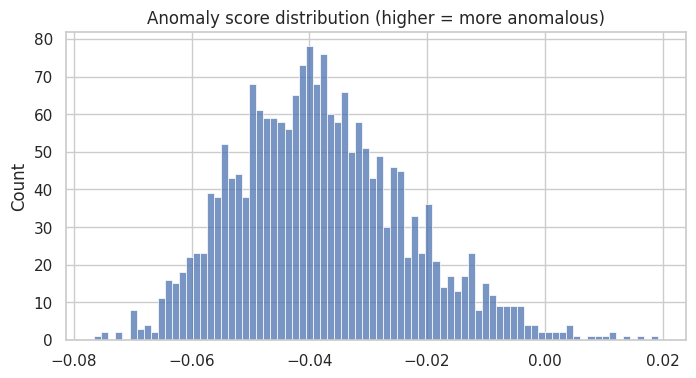

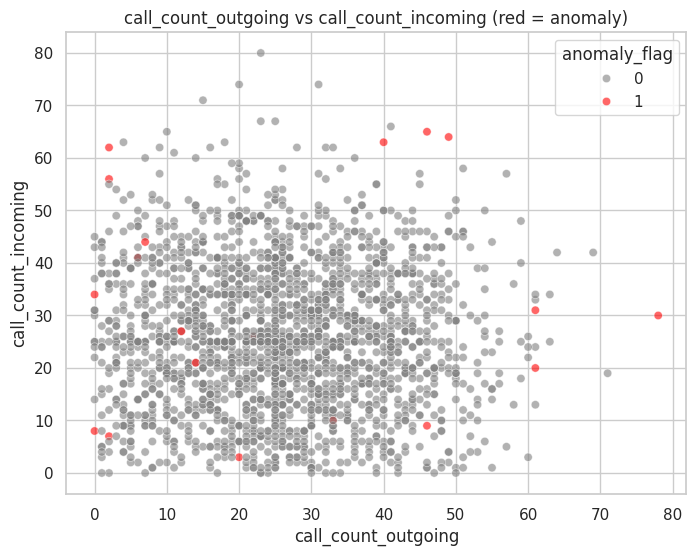

In [ ]:
# Step 12: visuals
plt.figure(figsize=(8,4))
sns.histplot(anomaly_score, bins=80)
plt.title("Anomaly score distribution (higher = more anomalous)")
plt.show()

# Scatter: pick two numeric features that exist
if len(num_features) >= 2:
    a, b = num_features[0], num_features[1]
    vis = X_test_raw.reset_index(drop=True).copy()
    vis['anomaly_flag'] = y_pred_binary
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=vis, x=a, y=b, hue='anomaly_flag', palette={0:'grey',1:'red'}, alpha=0.6)
    plt.title(f"{a} vs {b} (red = anomaly)")
    plt.show()


In [ ]:
# Step 13: save artifacts
artifact = {
    'preprocessor': preprocessor,
    'isoforest': iso,
    'num_features': num_features,
    'cat_for_onehot': cat_for_onehot
}
joblib.dump(artifact, 'isoforest_sim_pipeline.joblib')
print("Saved isoforest_sim_pipeline.joblib. Download it or copy to Drive for deployment.")


Saved isoforest_sim_pipeline.joblib. Download it or copy to Drive for deployment.


In [ ]:
preds = iso.predict(X_train)
print(preds[:20])


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
scores = iso.decision_function(X_train)
print(scores[:20])


[0.03499024 0.01887478 0.04861072 0.00364229 0.03769044 0.04899445
 0.04778769 0.04699877 0.04690145 0.02603463 0.05072646 0.03605778
 0.058615   0.04359308 0.02454376 0.04776751 0.0366568  0.03038376
 0.03632059 0.03712243]


In [ ]:
import numpy as np

unique, counts = np.unique(preds, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(-1): np.int64(90), np.int64(1): np.int64(7910)}


In [ ]:
import joblib

joblib.dump(iso, "isolation_forest_sim.pkl")
print("Model saved!")


Model saved!


In [ ]:
iso_loaded = joblib.load("isolation_forest_sim.pkl")
print("Model loaded!")


Model loaded!


In [ ]:
import numpy as np
import pandas as pd

# Example: new SIM usage
new_data = pd.DataFrame([{
    "call_count_outgoing": 2500,   # very high calls
    "call_count_incoming": 5,      # very low incoming
    "avg_call_duration": 0.1,      # too short
    "data_usage_mb": 40000,        # huge data usage (changed from gb to mb to match training data)
    "sms_count_sent": 0,           # placeholder
    "sms_count_received": 0,       # placeholder
    "avg_daily_usage": 1500,       # estimate based on data_usage_mb
    "usage_variance": 500,         # placeholder
    "is_company_number": 0,        # not company SIM
    "phone_prefix": '999',         # rare prefix (as string)
    "status": "Active",            # placeholder
    "registered_location": "Unknown", # placeholder
    "current_location": "Unknown"  # placeholder
}])

# The preprocessor expects the original raw features.
# We need to ensure new_data has columns present in X_raw that are used in the preprocessor.
raw_features_used_in_training = [c for c in X_raw.columns if (c in num_features and not c.endswith('_freq')) or c in cat_for_onehot or c in freq_encode_cols]

# Add any missing columns from the original raw features with default values
for col in raw_features_used_in_training:
    if col not in new_data.columns:
        if col in num_features:
            new_data[col] = 0
        elif col in cat_for_onehot or col in freq_encode_cols:
             new_data[col] = 'Unknown'

# Select and reorder columns to match the training data used by the preprocessor
new_data = new_data[raw_features_used_in_training]

In [ ]:
new_data = pd.DataFrame([{
    "call_count_outgoing": 2500,
    "call_count_incoming": 5,
    "avg_call_duration": 0.1,
    "sms_count_sent": 200,
    "sms_count_received": 10,
    "avg_daily_usage": 40,
    "usage_variance": 15,
    "phone_prefix": '999',  # Changed to string
    "is_company_number": 0,
    "status": "Active",
    "registered_location": "Delhi",
    "current_location": "Mumbai",
    # Add other raw features used in training with placeholder values if needed
    "data_usage_mb": 0 # Added missing raw feature
}])

# Ensure new_data has all raw features used in training with correct data types and order
# Get the list of original raw features used for training from X_raw before frequency encoding
raw_features_used_in_training = [col for col in X_raw.columns if col in (num_features + cat_features) and not col.endswith('_freq')]


# Add any missing columns from the original raw features with default values
for col in raw_features_used_in_training:
    if col not in new_data.columns:
        if col in num_features:
            new_data[col] = 0
        elif col in cat_features:
             new_data[col] = 'Unknown'

# Select and reorder columns to match the training data used by the preprocessor
new_data = new_data[raw_features_used_in_training]

In [ ]:
import pandas as pd

def predict_sim_anomaly(sim_record, preprocessor, model, raw_features, cat_for_onehot=[]):
    """
    Predicts if a SIM record is anomalous using a pre-fitted Isolation Forest.

    Parameters:
    - sim_record: dict containing SIM features
    - preprocessor: fitted sklearn ColumnTransformer / pipeline
    - model: fitted Isolation Forest
    - raw_features: list of all original raw features used in training (before freq encoding etc.)
    - cat_for_onehot: list of categorical features (for filling missing values with 'Unknown')

    Returns:
    - prediction: 1 (normal) or -1 (anomaly)
    - score: anomaly score (lower = more anomalous)
    """
    # Convert dict to DataFrame
    new_data = pd.DataFrame([sim_record])

    # Ensure all original raw features are present
    for col in raw_features:
        if col not in new_data.columns:
            # Use appropriate default based on expected type
            if col in cat_for_onehot or col in [f for f in preprocessor.transformers_[0][2] if f.endswith('_freq')]: # Check if it's a categorical feature or freq encoded source
                 new_data[col] = 'Unknown'
            else:
                 new_data[col] = 0 # Default for numeric


    # Ensure phone_prefix is string type if it's in raw_features
    if 'phone_prefix' in new_data.columns:
      new_data['phone_prefix'] = new_data['phone_prefix'].astype(str)

    # Reorder columns to match the order in raw_features
    new_data = new_data[raw_features]

    # Transform & predict
    new_data_transformed = preprocessor.transform(new_data)
    prediction = model.predict(new_data_transformed)
    score = model.decision_function(new_data_transformed)

    return prediction[0], score[0]

In [ ]:
import pandas as pd
import numpy as np # Import numpy

def predict_sim_anomaly(new_data_df, preprocessor, model, raw_features_list, original_cat_features=[], freq_encode_cols_info={}):
    """
    Predict anomaly for one or more SIM records.

    Parameters:
    - new_data_df: pandas DataFrame with new SIM records
    - preprocessor: fitted sklearn preprocessor (ColumnTransformer / Pipeline)
    - model: trained Isolation Forest
    - raw_features_list: list of features used in training (original raw features, including freq encoded)
    - original_cat_features: list of original categorical features (needed to create freq encoding if missing)
    - freq_encode_cols_info: dictionary containing frequency information for freq-encoded columns

    Returns:
    - DataFrame with original records + prediction + anomaly score
    """
    processed_data_df = new_data_df.copy()

    # Ensure original categorical columns needed for freq encoding are present
    for col in freq_encode_cols_info.keys():
        if col not in processed_data_df.columns:
            processed_data_df[col] = "Unknown" # Fill missing original categorical with 'Unknown'

    # Create frequency encoded features for the new data based on training frequencies
    for col, freq_map in freq_encode_cols_info.items():
        processed_data_df[col + "_freq"] = processed_data_df[col].map(freq_map).fillna(0.0)


    # Ensure all features expected by the preprocessor (original and freq-encoded) are present, filling others
    expected_features = raw_features_list

    for col in expected_features:
        if col not in processed_data_df.columns:
            if col in original_cat_features or col.replace('_freq', '') in freq_encode_cols_info.keys():
                processed_data_df[col] = "Unknown"
            elif col.endswith('_freq'):
                 processed_data_df[col] = 0.0
            else:
                 processed_data_df[col] = 0


    # Ensure phone_prefix is string type if it's in expected_features
    if 'phone_prefix' in processed_data_df.columns:
        processed_data_df['phone_prefix'] = processed_data_df['phone_prefix'].astype(str)


    # Select only the expected features and maintain their order
    processed_data_df = processed_data_df[expected_features]

    # Transform using the fitted preprocessor
    transformed = preprocessor.transform(processed_data_df)

    # Predict using trained Isolation Forest
    preds = model.predict(transformed)
    scores = model.decision_function(transformed)

    # Add results to DataFrame
    result_df = new_data_df.copy() # Use original input data for results
    result_df['prediction'] = preds
    result_df['anomaly_score'] = scores

    return result_df

In [ ]:
# Make sure your original data contains the same features
# Keep only features used in training
raw_features_used_in_training = [col for col in X_raw.columns if col in (num_features + cat_features) and not col.endswith('_freq')]
full_data_subset = df[raw_features_used_in_training].copy()

# Placeholder for new_records - replace with your actual new data
# Assuming new_records is a pandas DataFrame with the same columns as raw_features_used_in_training
new_records = pd.DataFrame([{
    "call_count_outgoing": 10,
    "call_count_incoming": 5,
    "avg_call_duration": 2.5,
    "sms_count_sent": 5,
    "sms_count_received": 3,
    "avg_daily_usage": 500,
    "usage_variance": 100,
    "phone_prefix": '9876',
    "is_company_number": 0,
    "status": "Active",
    "registered_location": "Mumbai",
    "current_location": "Mumbai",
    "data_usage_mb": 2000
}])

# Ensure new_records has the same columns and order as full_data_subset
new_records = new_records[raw_features_used_in_training]


# Append new records
combined_data = pd.concat([full_data_subset, new_records], ignore_index=True)

In [ ]:
# Fill missing columns
for col in raw_features_used_in_training:
    if col not in new_records.columns:
        # If categorical, fill with "Unknown", else numeric 0
        if col in ['status', 'registered_location', 'current_location']:
            new_records[col] = "Unknown"
        else:
            new_records[col] = 0

# Drop any extra columns that are not in training
new_records = new_records[raw_features_used_in_training]


In [ ]:
combined_data = pd.concat([full_data_subset, new_records], ignore_index=True)


In [ ]:
# Fill missing categorical columns in new_records
for col in ['status','registered_location','current_location','phone_prefix']:
    if col not in new_records.columns:
        new_records[col] = "Unknown"


In [ ]:
# Keep only features used in training and in correct order
new_records = new_records[raw_features_used_in_training]
full_data_subset = full_data_subset[raw_features_used_in_training]

# Combine
combined_data = pd.concat([full_data_subset, new_records], ignore_index=True)


In [ ]:
print("Features expected by IsolationForest:", iso.n_features_in_)
print("Columns in combined_data:", combined_data.columns.tolist())


Features expected by IsolationForest: 27
Columns in combined_data: ['call_count_outgoing', 'call_count_incoming', 'avg_call_duration', 'sms_count_sent', 'sms_count_received', 'avg_daily_usage', 'usage_variance', 'is_company_number', 'phone_prefix', 'status', 'registered_location', 'current_location']


In [ ]:
missing_cols = [c for c in raw_features_used_in_training if c not in combined_data.columns]
extra_cols = [c for c in combined_data.columns if c not in raw_features_used_in_training]
print("Missing columns:", missing_cols)
print("Extra columns:", extra_cols)


Missing columns: []
Extra columns: []


In [ ]:
import pandas as pd

def predict_anomalies_with_new_records(
    df_original,
    new_records,
    preprocessor,
    model,
    raw_features,
    cat_features,
    phone_col_candidates=['phone', 'Phone no'],
    pref_len=4
):
    """
    Combine original dataset with new SIM records and predict anomalies safely.

    Parameters:
    - df_original: original DataFrame used for training
    - new_records: new SIM records DataFrame
    - preprocessor: fitted ColumnTransformer / Pipeline
    - model: trained IsolationForest
    - raw_features: list of features used in training
    - cat_features: list of categorical features
    - phone_col_candidates: list of possible phone column names to create phone_prefix
    - pref_len: number of digits for phone_prefix

    Returns:
    - DataFrame with predictions and anomaly scores
    """
    # Step 1: Ensure phone_prefix exists in original data
    if 'phone_prefix' not in df_original.columns:
        phone_col = next((c for c in phone_col_candidates if c in df_original.columns), None)
        if phone_col:
            df_original['phone_prefix'] = df_original[phone_col].astype(str).str[:pref_len].fillna('UNK')
        else:
            df_original['phone_prefix'] = "UNK"

    # Step 2: Ensure phone_prefix exists in new_records
    if 'phone_prefix' not in new_records.columns:
        phone_col = next((c for c in phone_col_candidates if c in new_records.columns), None)
        if phone_col:
            new_records['phone_prefix'] = new_records[phone_col].astype(str).str[:pref_len].fillna('UNK')
        else:
            new_records['phone_prefix'] = "UNK"

    # Step 3: Create phone_prefix_freq based on original data
    prefix_freq_map = df_original['phone_prefix'].value_counts(normalize=True).to_dict()
    df_original['phone_prefix_freq'] = df_original['phone_prefix'].map(prefix_freq_map).fillna(0)
    new_records['phone_prefix_freq'] = new_records['phone_prefix'].map(prefix_freq_map).fillna(0)

    # Step 4: Ensure all required columns exist in new_records
    for col in raw_features:
        if col not in new_records.columns:
            if col in cat_features:
                new_records[col] = "Unknown"
            else:
                new_records[col] = 0

    # Step 5: Keep only training features in correct order
    new_records = new_records[raw_features]
    df_original_subset = df_original[raw_features].copy()

    # Step 6: Combine datasets
    combined_data = pd.concat([df_original_subset, new_records], ignore_index=True)

    # Step 7: Transform and predict
    transformed = preprocessor.transform(combined_data)
    preds = model.predict(transformed)
    scores = model.decision_function(transformed)

    # Step 8: Return results
    result_df = combined_data.copy()
    result_df['prediction'] = preds
    result_df['anomaly_score'] = scores

    return result_df


In [ ]:
print("Number of features IsolationForest expects:", iso.n_features_in_)
print("Features used during training:", raw_features_used_in_training)


Number of features IsolationForest expects: 27
Features used during training: ['call_count_outgoing', 'call_count_incoming', 'avg_call_duration', 'sms_count_sent', 'sms_count_received', 'avg_daily_usage', 'usage_variance', 'is_company_number', 'phone_prefix', 'status', 'registered_location', 'current_location']


In [ ]:
for col in ['call_count_outgoing', 'call_count_incoming', 'avg_call_duration',
            'sms_count_sent', 'sms_count_received', 'avg_daily_usage', 'usage_variance',
            'phone_prefix', 'phone_prefix_freq', 'is_company_number',
            'status','registered_location','current_location']:
    if col not in combined_data.columns:
        if col in ['status','registered_location','current_location','phone_prefix']:
            combined_data[col] = 'Unknown'
        else:
            combined_data[col] = 0


In [ ]:
combined_data = combined_data[raw_features_used_in_training]


In [ ]:
import pandas as pd

def predict_anomalies_with_new_records_fixed(
    df_original,
    new_records,
    preprocessor,
    model,
    raw_features,
    cat_features,
    phone_col_candidates=['phone', 'Phone no'],
    pref_len=4
):
    """
    Combine original dataset with new SIM records and predict anomalies safely.
    Handles phone_prefix, phone_prefix_freq, missing columns, and OneHotEncoder category issues.
    """

    # 1️⃣ Ensure phone_prefix exists
    for df in [df_original, new_records]:
        if 'phone_prefix' not in df.columns:
            phone_col = next((c for c in phone_col_candidates if c in df.columns), None)
            if phone_col:
                df['phone_prefix'] = df[phone_col].astype(str).str[:pref_len].fillna('UNK')
            else:
                df['phone_prefix'] = "UNK"

    # 2️⃣ Ensure phone_prefix_freq exists
    prefix_freq_map = df_original['phone_prefix'].value_counts(normalize=True).to_dict()
    for df in [df_original, new_records]:
        df['phone_prefix_freq'] = df['phone_prefix'].map(prefix_freq_map).fillna(0)

    # 3️⃣ Ensure all raw_features exist in new_records
    for col in raw_features:
        if col not in new_records.columns:
            if col in cat_features:
                new_records[col] = "Unknown"
            else:
                new_records[col] = 0

    # 4️⃣ Keep only raw_features columns
    new_records = new_records[raw_features]
    df_original_subset = df_original[raw_features].copy()

    # 5️⃣ Combine old + new data
    combined_data = pd.concat([df_original_subset, new_records], ignore_index=True)

    # 6️⃣ Ensure categorical columns are string type
    for cat in cat_features:
        combined_data[cat] = combined_data[cat].astype(str)

    # 7️⃣ Transform with preprocessor
    transformed = preprocessor.transform(combined_data)

    # 8️⃣ Predict
    preds = model.predict(transformed)
    scores = model.decision_function(transformed)

    # 9️⃣ Return results
    result_df = combined_data.copy()
    result_df['prediction'] = preds
    result_df['anomaly_score'] = scores

    return result_df


In [ ]:
# Example: force missing categories to "Unknown"
for cat_col in ['status','registered_location','current_location','phone_prefix']:
    # Ensure the column exists
    if cat_col not in combined_data.columns:
        combined_data[cat_col] = 'Unknown'
    # Convert to string to avoid dtype issues
    combined_data[cat_col] = combined_data[cat_col].astype(str)


In [ ]:
# Numeric features from your dataset
numeric_features = [
    'call_count_outgoing', 'call_count_incoming', 'avg_call_duration',
    'sms_count_sent', 'sms_count_received', 'avg_daily_usage',
    'usage_variance', 'phone_prefix_freq', 'is_company_number'
]

# Categorical features
cat_features = ['status','registered_location','current_location','phone_prefix']


In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_transformer = StandardScaler()


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)


In [ ]:
# Numeric features
numeric_features = [
    'call_count_outgoing', 'call_count_incoming', 'avg_call_duration',
    'sms_count_sent', 'sms_count_received', 'avg_daily_usage',
    'usage_variance', 'phone_prefix_freq', 'is_company_number' # Include phone_prefix_freq here
]

# Categorical features
cat_features = ['status','registered_location','current_location','phone_prefix']

In [ ]:
# Create phone_prefix if missing
for df_loop in [df, new_records]:
    if 'phone_prefix' not in df_loop.columns:
        phone_col = next((c for c in ['phone','Phone no'] if c in df_loop.columns), None)
        if phone_col:
            df_loop['phone_prefix'] = df_loop[phone_col].astype(str).str[:4].fillna('UNK')
        else:
            df_loop['phone_prefix'] = 'UNK'

# Create phone_prefix_freq
# Use the original df to calculate frequencies to ensure consistency
prefix_freq_map = df['phone_prefix'].value_counts(normalize=True).to_dict()
for df_loop in [df, new_records]:
    df_loop['phone_prefix_freq'] = df_loop['phone_prefix'].map(prefix_freq_map).fillna(0)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Fit preprocessor on training data (use df as the full training data)
preprocessor.fit(df[numeric_features + cat_features])

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['call_count_outgoing', 'call_count_incoming',
                                  'avg_call_duration', 'sms_count_sent',
                                  'sms_count_received', 'avg_daily_usage',
                                  'usage_variance', 'phone_prefix_freq',
                                  'is_company_number']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['status', 'registered_location',
                                  'current_location', 'phone_prefix'])])

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Fit preprocessor on training data
preprocessor.fit(df[numeric_features + cat_features])


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['call_count_outgoing', 'call_count_incoming',
                                  'avg_call_duration', 'sms_count_sent',
                                  'sms_count_received', 'avg_daily_usage',
                                  'usage_variance', 'phone_prefix_freq',
                                  'is_company_number']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['status', 'registered_location',
                                  'current_location', 'phone_prefix'])])

In [ ]:
from sklearn.ensemble import IsolationForest

# Transform the original training data using the refitted preprocessor
X_train_transformed = preprocessor.transform(df[numeric_features + cat_features])

# Train Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train_transformed)

IsolationForest(contamination=0.05, random_state=42)

In [ ]:
import pandas as pd

def predict_new_sims(df_original, new_records, preprocessor, model, numeric_features, cat_features):
    # Ensure all required columns exist
    for col in numeric_features + cat_features:
        if col not in new_records.columns:
            if col in cat_features:
                new_records[col] = "Unknown"
            else:
                new_records[col] = 0

    # Keep columns in correct order
    new_records = new_records[numeric_features + cat_features]

    # Combine original + new
    combined = pd.concat([df_original[numeric_features + cat_features], new_records], ignore_index=True)

    # Transform and predict
    X_transformed = preprocessor.transform(combined)
    preds = model.predict(X_transformed)
    scores = model.decision_function(X_transformed)

    result = combined.copy()
    result['prediction'] = preds
    result['anomaly_score'] = scores

    return result


In [ ]:
combined_results = predict_new_sims(
    df_original=df,
    new_records=new_records,
    preprocessor=preprocessor,
    model=iso,
    numeric_features=numeric_features,
    cat_features=cat_features
)

# View predictions
print(combined_results)


       call_count_outgoing  call_count_incoming  avg_call_duration  \
0                        1                   47           3.480000   
1                       45                   41           7.310000   
2                       24                    6           4.230000   
3                       45                    4           1.410000   
4                       41                    4           6.480000   
...                    ...                  ...                ...   
9996                    13                   29           5.423697   
9997                    30                   25           4.102003   
9998                    39                   37           3.303919   
9999                     6                    3           7.674294   
10000                   10                    5           2.500000   

       sms_count_sent  sms_count_received  avg_daily_usage  usage_variance  \
0                   7                   4      1251.510000     1728.249128   
1  

In [ ]:
import pandas as pd

# Create some suspicious SIM usage examples
test_data = pd.DataFrame([
    # Normal usage (baseline, like you already had)
    {
        "call_count_outgoing": 10,
        "call_count_incoming": 5,
        "avg_call_duration": 2.5,
        "sms_count_sent": 5,
        "sms_count_received": 3,
        "avg_daily_usage": 500,
        "usage_variance": 100,
        "phone_prefix_freq": 1.0,
        "is_company_number": 0,
        "status": "Active",
        "registered_location": "Mumbai",
        "current_location": "Mumbai",
        "phone_prefix": "UNK"
    },

    # 🚨 Anomaly 1: Sudden huge usage
    {
        "call_count_outgoing": 500,
        "call_count_incoming": 400,
        "avg_call_duration": 50,
        "sms_count_sent": 1000,
        "sms_count_received": 900,
        "avg_daily_usage": 100000,
        "usage_variance": 50000,
        "phone_prefix_freq": 0.1,
        "is_company_number": 0,
        "status": "Active",
        "registered_location": "Mumbai",
        "current_location": "Mumbai",
        "phone_prefix": "UNK"
    },

    # 🚨 Anomaly 2: SIM is Active but never used
    {
        "call_count_outgoing": 0,
        "call_count_incoming": 0,
        "avg_call_duration": 0,
        "sms_count_sent": 0,
        "sms_count_received": 0,
        "avg_daily_usage": 0,
        "usage_variance": 0,
        "phone_prefix_freq": 0.5,
        "is_company_number": 0,
        "status": "Active",
        "registered_location": "Delhi",
        "current_location": "Delhi",
        "phone_prefix": "UNK"
    },

    # 🚨 Anomaly 3: Location mismatch
    {
        "call_count_outgoing": 20,
        "call_count_incoming": 15,
        "avg_call_duration": 3,
        "sms_count_sent": 8,
        "sms_count_received": 10,
        "avg_daily_usage": 300,
        "usage_variance": 50,
        "phone_prefix_freq": 0.9,
        "is_company_number": 0,
        "status": "Active",
        "registered_location": "Pune",
        "current_location": "Dubai",  # mismatch with registration
        "phone_prefix": "UNK"
    }
])

# Run through your model (replace with your function)
# Example: predictions = model.predict(test_data)
# Example: scores = model.decision_function(test_data) or model.score_samples(test_data)

print(test_data)


   call_count_outgoing  call_count_incoming  avg_call_duration  \
0                   10                    5                2.5   
1                  500                  400               50.0   
2                    0                    0                0.0   
3                   20                   15                3.0   

   sms_count_sent  sms_count_received  avg_daily_usage  usage_variance  \
0               5                   3              500             100   
1            1000                 900           100000           50000   
2               0                   0                0               0   
3               8                  10              300              50   

   phone_prefix_freq  is_company_number  status registered_location  \
0                1.0                  0  Active              Mumbai   
1                0.1                  0  Active              Mumbai   
2                0.5                  0  Active               Delhi   
3             

In [ ]:
# ✅ 1. Transform the raw test data with the same preprocessor used in training
test_data_transformed = preprocessor.transform(test_data)

# ✅ 2. Run predictions with the IsolationForest
predictions = iso.predict(test_data_transformed)
# 1 = normal, -1 = anomaly

# ✅ 3. Get anomaly scores (lower = more anomalous)
scores = iso.decision_function(test_data_transformed)

# ✅ 4. Attach predictions + scores back to original test data
test_data["prediction"] = predictions
test_data["anomaly_score"] = scores

# ✅ 5. Display results
print(test_data[[
    "call_count_outgoing", "call_count_incoming", "avg_call_duration",
    "sms_count_sent", "sms_count_received", "avg_daily_usage",
    "usage_variance", "registered_location", "current_location",
    "prediction", "anomaly_score"
]])


   call_count_outgoing  call_count_incoming  avg_call_duration  \
0                   10                    5                2.5   
1                  500                  400               50.0   
2                    0                    0                0.0   
3                   20                   15                3.0   

   sms_count_sent  sms_count_received  avg_daily_usage  usage_variance  \
0               5                   3              500             100   
1            1000                 900           100000           50000   
2               0                   0                0               0   
3               8                  10              300              50   

  registered_location current_location  prediction  anomaly_score  
0              Mumbai           Mumbai           1       0.001279  
1              Mumbai           Mumbai          -1      -0.022244  
2               Delhi            Delhi          -1      -0.009964  
3                Pune     

In [ ]:
# Step 1: retrain model with higher contamination
# Moved model training to a separate cell (YFgZ1VJQLLg7) for clarity
# iso = IsolationForest(
#     n_estimators=200,
#     max_samples='auto',
#     contamination=0.2,   # increase anomaly proportion to 20%
#     random_state=42,
#     n_jobs=-1
# )

# Ensure phone_prefix and phone_prefix_freq are in test_data before transforming
# Use the original df to get the frequency map for phone_prefix
if 'phone_prefix' not in test_data.columns:
    test_data['phone_prefix'] = 'UNK' # or derive from phone number if available

# Use the original df to get the frequency map for phone_prefix
if 'phone_prefix' in df.columns: # Check if phone_prefix was created in the original df
    prefix_freq_map = df['phone_prefix'].value_counts(normalize=True).to_dict()
    test_data['phone_prefix_freq'] = test_data['phone_prefix'].map(prefix_freq_map).fillna(0)
else:
    test_data['phone_prefix_freq'] = 0.0 # Default if original df doesn't have phone_prefix


# iso.fit(X_train)  # or fit only on normal samples if you have labels
# Model fitting is now done in cell YFgZ1VJQLLg7

# Step 2: test again
# Ensure test_data has the columns in the order expected by the preprocessor
# Use the updated numeric_features list
expected_cols = numeric_features + cat_features

# Make sure all expected columns are in test_data, adding missing ones with default values
for col in expected_cols:
    if col not in test_data.columns:
        if col in cat_features:
            test_data[col] = "Unknown"
        else:
            test_data[col] = 0

# Ensure categorical columns are strings
for col in cat_features:
     if col in test_data.columns:
        test_data[col] = test_data[col].astype(str)


test_data_ordered = test_data[expected_cols]


# Transform the test data using the fitted preprocessor
test_data_transformed = preprocessor.transform(test_data_ordered)

# Predict using the trained Isolation Forest model
predictions = iso.predict(test_data_transformed)
scores = iso.decision_function(test_data_transformed)  # higher = more normal

# Add predictions and scores back to the original test_data DataFrame (or a copy)
# Create a copy to avoid modifying the original test_data in place if it's used elsewhere
test_results = test_data.copy()
test_results["prediction"] = predictions
test_results["anomaly_score"] = scores

print(test_results[[
    "call_count_outgoing", "call_count_incoming", "avg_call_duration",
    "sms_count_sent", "sms_count_received", "avg_daily_usage",
    "usage_variance", "registered_location", "current_location",
    "prediction", "anomaly_score"
]])

   call_count_outgoing  call_count_incoming  avg_call_duration  \
0                   10                    5                2.5   
1                  500                  400               50.0   
2                    0                    0                0.0   
3                   20                   15                3.0   

   sms_count_sent  sms_count_received  avg_daily_usage  usage_variance  \
0               5                   3              500             100   
1            1000                 900           100000           50000   
2               0                   0                0               0   
3               8                  10              300              50   

  registered_location current_location  prediction  anomaly_score  
0              Mumbai           Mumbai           1       0.002850  
1              Mumbai           Mumbai          -1      -0.020750  
2               Delhi            Delhi          -1      -0.007275  
3                Pune     

In [ ]:
preds = iso.predict(X_train_transformed)
pd.Series(preds).value_counts()


,count
1,9500
-1,500


In [ ]:
scores = iso.decision_function(X_train_transformed)
print(scores.min(), scores.max())


-0.013823998086793188 0.014743292214773218


In [ ]:
from sklearn.ensemble import IsolationForest

# Step 1: retrain with higher contamination
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.2,   # 20% anomalies expected (tune later)
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_transformed)

# Step 2: check predictions again
preds = iso.predict(X_train_transformed)
print(pd.Series(preds).value_counts())

# Step 3: check anomaly scores
scores = iso.decision_function(X_train_transformed)
print("Score range:", scores.min(), "to", scores.max())


 1    8000
-1    2000
Name: count, dtype: int64
Score range: -0.010888569030233664 to 0.009783087410274949


In [ ]:
print("Raw data shape:", X_raw.shape)
print("Head of raw data:\n", X_raw.head())


Raw data shape: (10000, 13)
Head of raw data:
    call_count_outgoing  call_count_incoming  avg_call_duration  \
0                    1                   47               3.48   
1                   45                   41               7.31   
2                   24                    6               4.23   
3                   45                    4               1.41   
4                   41                    4               6.48   

   sms_count_sent  sms_count_received  avg_daily_usage  usage_variance  \
0               7                   4      1251.510000     1728.249128   
1              13                   7       793.193333     1047.138167   
2              11                  19       473.126667      626.675742   
3               7                   9      1663.950000     2307.258049   
4               5                  17      1242.060000     1709.187735   

   is_company_number phone_prefix       status registered_location  \
0                  0         8484       A

In [ ]:
X_transformed = preprocessor.fit_transform(X_raw)   # use all rows
print("Transformed shape:", X_transformed.shape)


Transformed shape: (10000, 2920)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Use the actual numerical and categorical features from your dataset
numerical_features = [
    "call_count_outgoing", "call_count_incoming", "avg_call_duration",
    "sms_count_sent", "sms_count_received", # Removed 'data_usage_mb'
    "avg_daily_usage", "usage_variance", "phone_prefix_freq", "is_company_number"
]
categorical_features = ["status", "registered_location", "current_location", "phone_prefix"]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder="passthrough"
)

# Ensure the columns used in the preprocessor exist in X_raw before fitting
cols_to_check = numerical_features + categorical_features

# Select only the columns that are expected by the preprocessor
X_raw_subset = X_raw[cols_to_check]


X_transformed = preprocessor.fit_transform(X_raw_subset) # Use the subset
print("New shape:", X_transformed.shape)

New shape: (10000, 2920)


In [ ]:
# Use the actual numerical and categorical features from your dataset
numerical_features = [
    "call_count_outgoing", "call_count_incoming", "avg_call_duration",
    "sms_count_sent", "sms_count_received", # Removed 'data_usage_mb'
    "avg_daily_usage", "usage_variance", "phone_prefix_freq", "is_company_number"
]
categorical_features = ["status", "registered_location", "current_location", "phone_prefix"]

In [ ]:
cols_to_check = numerical_features + categorical_features
# Select only the columns that are expected by the preprocessor
# This explicitly creates a DataFrame subset with only the required columns
X_raw_subset = X_raw[cols_to_check]

In [ ]:
cols_to_check = numerical_features + categorical_features
X_raw_subset = X_raw[cols_to_check]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [ ]:
X_transformed = preprocessor.fit_transform(X_raw_subset)
print("Transformed shape:", X_transformed.shape)


Transformed shape: (10000, 2920)


In [ ]:
for col in categorical_features:
    print(col, X_raw[col].nunique())


status 3
registered_location 7
current_location 7
phone_prefix 2894


In [ ]:
# Categorical features (restoring the original list that the preprocessor was defined with)
categorical_features = ["status", "registered_location", "current_location", "phone_prefix"]

In [ ]:
cols_to_use = numerical_features + categorical_features
X_transformed = preprocessor.fit_transform(X_raw[cols_to_use])
print("New shape:", X_transformed.shape)

New shape: (10000, 2920)


In [ ]:
for col in categorical_features:
    print(col, X_raw[col].nunique())


status 3
registered_location 7
current_location 7
phone_prefix 2894


In [ ]:
numerical_features = [
    "call_count_outgoing", "call_count_incoming", "avg_call_duration",
    "sms_count_sent", "sms_count_received",
    "avg_daily_usage", "usage_variance", "phone_prefix_freq", "is_company_number" # Ensure these are correct
]
categorical_features = ["status", "registered_location", "current_location", "phone_prefix"] # Ensure these are correct

In [ ]:
cols_to_use = numerical_features + categorical_features
X_subset = X_raw[cols_to_use]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_transformed = preprocessor.fit_transform(X_subset)
print("New shape:", X_transformed.shape)

New shape: (10000, 2920)


In [ ]:
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


Numerical features: ['call_count_outgoing', 'call_count_incoming', 'avg_call_duration', 'sms_count_sent', 'sms_count_received', 'avg_daily_usage', 'usage_variance', 'phone_prefix_freq', 'is_company_number']
Categorical features: ['status', 'registered_location', 'current_location', 'phone_prefix']


In [ ]:
print(X_subset.columns.tolist())


['call_count_outgoing', 'call_count_incoming', 'avg_call_duration', 'sms_count_sent', 'sms_count_received', 'avg_daily_usage', 'usage_variance', 'phone_prefix_freq', 'is_company_number', 'status', 'registered_location', 'current_location', 'phone_prefix']


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# -------------------------
# 1️⃣ Define features
# -------------------------
numerical_features = [
    'call_count_outgoing', 'call_count_incoming', 'avg_call_duration',
    'sms_count_sent', 'sms_count_received', 'avg_daily_usage',
    'usage_variance', 'phone_prefix_freq', 'is_company_number'
]

# Keep only low-cardinality categorical columns
categorical_features = ['registered_location', 'current_location'] # Removed 'status' from categorical features as it's now the target

# Target column
target_column = 'status'  # Changed target column to 'status'

# -------------------------
# 2️⃣ Subset the dataset
# -------------------------
cols_to_use = numerical_features + categorical_features
X = X_raw[cols_to_use]
y = X_raw[target_column]

# -------------------------
# 3️⃣ Split into train/test
# -------------------------
# Stratify by 'status' if possible, otherwise a simple split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError: # Handle cases where stratification is not possible (e.g., single class)
     X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


print("Transformed training shape:", X_train.shape) # Shape before preprocessing
print("Transformed test shape:", X_test.shape)    # Shape before preprocessing


# -------------------------
# 4️⃣ Preprocessing
# -------------------------
# Define the preprocessor with the updated feature lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns like phone_prefix if not explicitly used
)


# Fit on training data, transform both train and test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed training shape:", X_train_transformed.shape)
print("Transformed test shape:", X_test_transformed.shape)

# -------------------------
# 5️⃣ Train a model (example)
# -------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Transformed training shape: (8000, 11)
Transformed test shape: (2000, 11)
Transformed training shape: (8000, 23)
Transformed test shape: (2000, 23)
Test Accuracy: 0.312

Classification Report:
               precision    recall  f1-score   support

      Active       0.31      0.33      0.32       676
 Deactivated       0.30      0.26      0.28       646
   Suspended       0.32      0.34      0.33       678

    accuracy                           0.31      2000
   macro avg       0.31      0.31      0.31      2000
weighted avg       0.31      0.31      0.31      2000



In [ ]:
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)
X_raw['avg_total_usage'] = (X_raw['avg_call_duration'] * X_raw['total_calls'] +
                            X_raw['avg_daily_usage']) / 2


In [ ]:
X_raw['high_call_volume'] = (X_raw['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_raw['high_sms_volume'] = (X_raw['sms_count_sent'] + X_raw['sms_count_received'] > X_raw['sms_count_sent'].median()).astype(int)


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# -------------------------
# 1️⃣ Define initial features
# -------------------------
numerical_features = [
    'call_count_outgoing', 'call_count_incoming', 'avg_call_duration',
    'sms_count_sent', 'sms_count_received', 'avg_daily_usage',
    'usage_variance', 'is_company_number'
]

categorical_features = ['status', 'registered_location', 'current_location']  # exclude raw phone_prefix

target_column = 'status'

# -------------------------
# 2️⃣ Encode phone_prefix as frequency
# -------------------------
prefix_counts = X_raw['phone_prefix'].value_counts()
X_raw['phone_prefix_freq'] = X_raw['phone_prefix'].map(prefix_counts)

numerical_features.append('phone_prefix_freq')  # now treated as numeric

# -------------------------
# 3️⃣ Feature Engineering
# -------------------------
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)
X_raw['high_call_volume'] = (X_raw['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_raw['high_sms_volume'] = ((X_raw['sms_count_sent'] + X_raw['sms_count_received']) >
                            (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

# Add engineered features to numerical list
numerical_features += ['total_calls', 'call_ratio_out_in', 'sms_ratio_sent_received', 'high_call_volume', 'high_sms_volume']

# -------------------------
# 4️⃣ Subset dataset
# -------------------------
cols_to_use = numerical_features + categorical_features
X = X_raw[cols_to_use]
y = X_raw[target_column]

# -------------------------
# 5️⃣ Split train/test
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 6️⃣ Preprocessing
# -------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed training shape:", X_train_transformed.shape)
print("Transformed test shape:", X_test_transformed.shape)

# -------------------------
# 7️⃣ Train Isolation Forest
# -------------------------
# Train only on "normal" users (Active)
X_train_normal = X_train_transformed[y_train == 'Active']

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # adjust based on expected anomalies
    random_state=42
)
iso.fit(X_train_normal)

# -------------------------
# 8️⃣ Predict anomalies
# -------------------------
y_pred_anomaly = iso.predict(X_test_transformed)
# -1 = anomaly (Suspended/Deactivated), 1 = normal (Active)

# Map predictions to labels for evaluation
y_pred_labels = ['Active' if x==1 else 'Suspended/Deactivated' for x in y_pred_anomaly]

# -------------------------
# 9️⃣ Evaluation
# -------------------------
print("Classification Report:")
print(classification_report(
    y_test.map(lambda x: 'Active' if x=='Active' else 'Suspended/Deactivated'),
    y_pred_labels
))


Transformed training shape: (8000, 31)
Transformed test shape: (2000, 31)
Classification Report:
                       precision    recall  f1-score   support

               Active       0.32      0.94      0.48       651
Suspended/Deactivated       0.60      0.04      0.08      1349

             accuracy                           0.33      2000
            macro avg       0.46      0.49      0.28      2000
         weighted avg       0.51      0.33      0.21      2000



ROC-AUC for anomaly detection: 0.4751861480142883
Precision-Recall AUC: 0.6587106739953628


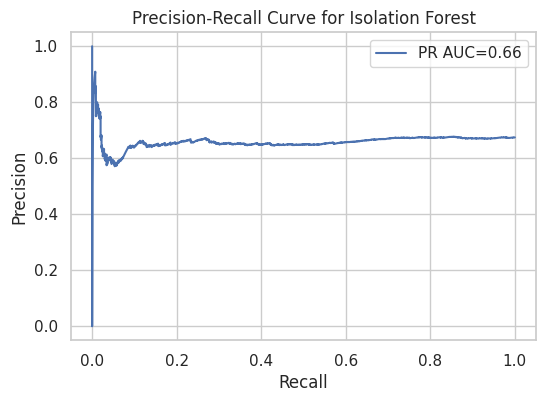

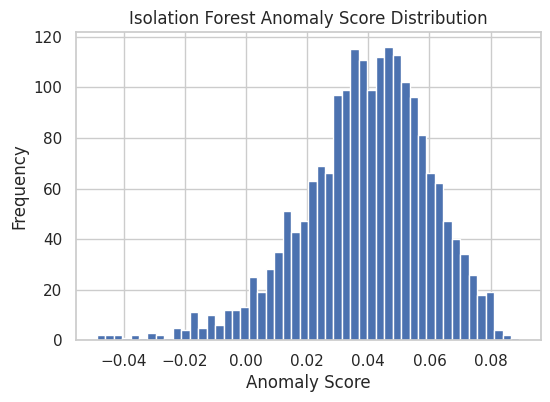

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# -------------------------
# 1️⃣ Define features
# -------------------------
numerical_features = [
    'call_count_outgoing', 'call_count_incoming', 'avg_call_duration',
    'sms_count_sent', 'sms_count_received', 'avg_daily_usage',
    'usage_variance', 'is_company_number'
]
categorical_features = ['status', 'registered_location', 'current_location']

# Encode phone_prefix as frequency
prefix_counts = X_raw['phone_prefix'].value_counts()
X_raw['phone_prefix_freq'] = X_raw['phone_prefix'].map(prefix_counts)
numerical_features.append('phone_prefix_freq')

# Feature engineering
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)
X_raw['high_call_volume'] = (X_raw['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_raw['high_sms_volume'] = ((X_raw['sms_count_sent'] + X_raw['sms_count_received']) >
                            (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

numerical_features += ['total_calls', 'call_ratio_out_in', 'sms_ratio_sent_received', 'high_call_volume', 'high_sms_volume']

# Target for evaluation only
target_column = 'status'
y = X_raw[target_column]

# -------------------------
# 2️⃣ Prepare features
# -------------------------
cols_to_use = numerical_features + categorical_features
X = X_raw[cols_to_use]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# -------------------------
# 3️⃣ Train Isolation Forest
# -------------------------
X_train_normal = X_train_transformed[y_train == 'Active']

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # expected proportion of anomalies
    random_state=42
)
iso.fit(X_train_normal)

# -------------------------
# 4️⃣ Predict anomaly scores
# -------------------------
anomaly_scores = iso.decision_function(X_test_transformed)  # higher = more normal
y_pred_anomaly = iso.predict(X_test_transformed)            # 1=inlier, -1=anomaly

# -------------------------
# 5️⃣ Evaluate using ROC-AUC
# -------------------------
# Map labels: 0=normal (Active), 1=anomaly (Suspended/Deactivated)
y_test_binary = y_test.map(lambda x: 0 if x=='Active' else 1)

roc_auc = roc_auc_score(y_test_binary, -anomaly_scores)  # lower scores = anomalies
print("ROC-AUC for anomaly detection:", roc_auc)

# -------------------------
# 6️⃣ Precision-Recall Curve
# -------------------------
precision, recall, thresholds = precision_recall_curve(y_test_binary, -anomaly_scores)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.legend()
plt.show()

# -------------------------
# 7️⃣ Anomaly score distribution
# -------------------------
plt.figure(figsize=(6,4))
plt.hist(anomaly_scores, bins=50)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import pandas as pd

# Example dummy data (single record)
dummy_data = pd.DataFrame([{
    'call_count_outgoing': 50,
    'call_count_incoming': 20,
    'avg_call_duration': 5.0,
    'sms_count_sent': 10,
    'sms_count_received': 5,
    'avg_daily_usage': 30,
    'usage_variance': 2.0,
    'is_company_number': 0,
    'phone_prefix_freq': 120,  # frequency of the prefix in your training data
    'status': 'Active',         # categorical
    'registered_location': 'Location_1',
    'current_location': 'Location_2'
}])

# Add engineered features same as training
dummy_data['total_calls'] = dummy_data['call_count_outgoing'] + dummy_data['call_count_incoming']
dummy_data['call_ratio_out_in'] = dummy_data['call_count_outgoing'] / (dummy_data['call_count_incoming'] + 1)
dummy_data['sms_ratio_sent_received'] = dummy_data['sms_count_sent'] / (dummy_data['sms_count_received'] + 1)
dummy_data['high_call_volume'] = (dummy_data['total_calls'] > X_raw['total_calls'].median()).astype(int)
dummy_data['high_sms_volume'] = ((dummy_data['sms_count_sent'] + dummy_data['sms_count_received']) >
                                 (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)


In [ ]:
dummy_transformed = preprocessor.transform(dummy_data)


In [ ]:
anomaly_pred = iso.predict(dummy_transformed)  # 1 = normal, -1 = anomaly
anomaly_score = iso.decision_function(dummy_transformed)  # numerical score

if anomaly_pred[0] == 1:
    print("Normal / Active")
else:
    print("Anomaly detected!")

print("Anomaly score:", anomaly_score[0])


Normal / Active
Anomaly score: 0.05069961683912738


In [ ]:
threshold = 0.0  # you can adjust based on ROC curve or desired sensitivity
if anomaly_score[0] < threshold:
    print("Anomaly detected!")
else:
    print("Normal / Active")


Normal / Active


In [ ]:
import pandas as pd

# Example suspicious / anomalous user
suspicious_data = pd.DataFrame([{
    'call_count_outgoing': 0,      # no outgoing calls
    'call_count_incoming': 0,      # no incoming calls
    'avg_call_duration': 0.1,      # extremely low
    'sms_count_sent': 1000,        # unusually high SMS count
    'sms_count_received': 1000,    # unusually high SMS count
    'avg_daily_usage': 500,        # very high daily usage
    'usage_variance': 50,          # extremely high variance
    'is_company_number': 0,
    'phone_prefix_freq': 1,        # very rare prefix
    'status': 'Active',            # label is normal but usage is suspicious
    'registered_location': 'Location_1',
    'current_location': 'Location_2'
}])

# Add engineered features exactly as training
suspicious_data['total_calls'] = suspicious_data['call_count_outgoing'] + suspicious_data['call_count_incoming']
suspicious_data['call_ratio_out_in'] = suspicious_data['call_count_outgoing'] / (suspicious_data['call_count_incoming'] + 1)
suspicious_data['sms_ratio_sent_received'] = suspicious_data['sms_count_sent'] / (suspicious_data['sms_count_received'] + 1)
suspicious_data['high_call_volume'] = (suspicious_data['total_calls'] > X_raw['total_calls'].median()).astype(int)
suspicious_data['high_sms_volume'] = ((suspicious_data['sms_count_sent'] + suspicious_data['sms_count_received']) >
                                      (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

# Preprocess
suspicious_transformed = preprocessor.transform(suspicious_data)

# Predict anomaly
anomaly_pred = iso.predict(suspicious_transformed)
anomaly_score = iso.decision_function(suspicious_transformed)

if anomaly_pred[0] == 1:
    print("Normal / Active")
else:
    print("Anomaly detected!")

print("Anomaly score:", anomaly_score[0])


Anomaly detected!
Anomaly score: -0.0017440734276301662


**batch of dummy users,**

In [ ]:
import pandas as pd

# -------------------------
# 1️⃣ Create dummy batch
# -------------------------
dummy_batch = pd.DataFrame([
    # Normal user
    {
        'call_count_outgoing': 30,
        'call_count_incoming': 20,
        'avg_call_duration': 5,
        'sms_count_sent': 10,
        'sms_count_received': 5,
        'avg_daily_usage': 30,
        'usage_variance': 2,
        'is_company_number': 0,
        'phone_prefix_freq': 120,
        'status': 'Active',
        'registered_location': 'Location_1',
        'current_location': 'Location_2'
    },
    # Suspicious user 1
    {
        'call_count_outgoing': 0,
        'call_count_incoming': 0,
        'avg_call_duration': 0.1,
        'sms_count_sent': 1000,
        'sms_count_received': 1000,
        'avg_daily_usage': 500,
        'usage_variance': 50,
        'is_company_number': 0,
        'phone_prefix_freq': 1,
        'status': 'Active',
        'registered_location': 'Location_3',
        'current_location': 'Location_4'
    },
    # Normal user
    {
        'call_count_outgoing': 25,
        'call_count_incoming': 15,
        'avg_call_duration': 4,
        'sms_count_sent': 8,
        'sms_count_received': 6,
        'avg_daily_usage': 25,
        'usage_variance': 1.5,
        'is_company_number': 1,
        'phone_prefix_freq': 90,
        'status': 'Active',
        'registered_location': 'Location_2',
        'current_location': 'Location_2'
    },
    # Suspicious user 2
    {
        'call_count_outgoing': 500,
        'call_count_incoming': 400,
        'avg_call_duration': 20,
        'sms_count_sent': 300,
        'sms_count_received': 250,
        'avg_daily_usage': 800,
        'usage_variance': 100,
        'is_company_number': 0,
        'phone_prefix_freq': 2,
        'status': 'Active',
        'registered_location': 'Location_5',
        'current_location': 'Location_6'
    }
])

# -------------------------
# 2️⃣ Add engineered features
# -------------------------
dummy_batch['total_calls'] = dummy_batch['call_count_outgoing'] + dummy_batch['call_count_incoming']
dummy_batch['call_ratio_out_in'] = dummy_batch['call_count_outgoing'] / (dummy_batch['call_count_incoming'] + 1)
dummy_batch['sms_ratio_sent_received'] = dummy_batch['sms_count_sent'] / (dummy_batch['sms_count_received'] + 1)
dummy_batch['high_call_volume'] = (dummy_batch['total_calls'] > X_raw['total_calls'].median()).astype(int)
dummy_batch['high_sms_volume'] = ((dummy_batch['sms_count_sent'] + dummy_batch['sms_count_received']) >
                                  (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

# -------------------------
# 3️⃣ Preprocess
# -------------------------
dummy_transformed = preprocessor.transform(dummy_batch)

# -------------------------
# 4️⃣ Predict anomalies
# -------------------------
anomaly_pred = iso.predict(dummy_transformed)
anomaly_score = iso.decision_function(dummy_transformed)

# -------------------------
# 5️⃣ Show results
# -------------------------
for i, row in dummy_batch.iterrows():
    status = "Normal / Active" if anomaly_pred[i] == 1 else "Anomaly detected!"
    print(f"User {i+1}: {status}, Anomaly score: {anomaly_score[i]:.4f}")


User 1: Normal / Active, Anomaly score: 0.0623
User 2: Anomaly detected!, Anomaly score: -0.0017
User 3: Normal / Active, Anomaly score: 0.0621
User 4: Anomaly detected!, Anomaly score: -0.0496


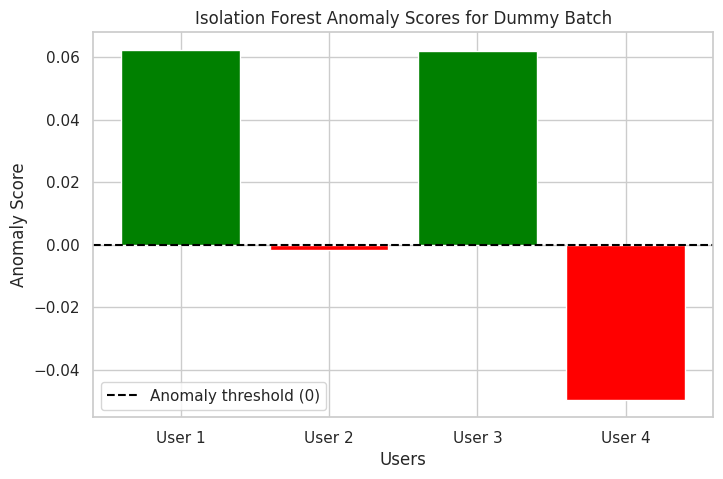

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ Prepare data for plotting
# -------------------------
user_ids = [f'User {i+1}' for i in range(len(dummy_batch))]
scores = anomaly_score
predictions = anomaly_pred

# Color based on prediction
colors = ['green' if pred == 1 else 'red' for pred in predictions]

# -------------------------
# 2️⃣ Plot
# -------------------------
plt.figure(figsize=(8,5))
plt.bar(user_ids, scores, color=colors)
plt.axhline(0, color='black', linestyle='--', label='Anomaly threshold (0)')
plt.xlabel('Users')
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest Anomaly Scores for Dummy Batch')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# -------------------------
# 1️⃣ Create result table
# -------------------------
results = dummy_batch.copy()

# Add predicted status and anomaly score
results['Predicted_Status'] = ['Normal / Active' if pred==1 else 'Anomaly detected!' for pred in anomaly_pred]
results['Anomaly_Score'] = anomaly_score

# Optional: select key features to show
key_features = ['call_count_outgoing', 'call_count_incoming', 'sms_count_sent', 'sms_count_received',
                'avg_daily_usage', 'usage_variance', 'phone_prefix_freq']

# Show table with predictions
display(results[['Predicted_Status', 'Anomaly_Score'] + key_features])


,Predicted_Status,Anomaly_Score,call_count_outgoing,call_count_incoming,sms_count_sent,sms_count_received,avg_daily_usage,usage_variance,phone_prefix_freq
0,Normal / Active,0.062326,30,20,10,5,30,2.0,120
1,Anomaly detected!,-0.001744,0,0,1000,1000,500,50.0,1
2,Normal / Active,0.062062,25,15,8,6,25,1.5,90
3,Anomaly detected!,-0.049619,500,400,300,250,800,100.0,2


In [ ]:
# 1️⃣ Fit (training)
iso.fit(X_train_normal)

# 2️⃣ Predict on test set
y_pred_test = iso.predict(X_test_transformed)
print("Sample predictions (1=inlier, -1=anomaly):", y_pred_test[:5])

# 3️⃣ Check anomaly scores
scores_test = iso.decision_function(X_test_transformed)
print("Sample anomaly scores:", scores_test[:5])

# 4️⃣ Test dummy users
dummy_transformed = preprocessor.transform(dummy_batch)
dummy_pred = iso.predict(dummy_transformed)
dummy_scores = iso.decision_function(dummy_transformed)

for i, user in enumerate(dummy_batch.index):
    status = "Normal / Active" if dummy_pred[i]==1 else "Anomaly detected!"
    print(f"User {i+1}: {status}, Anomaly score: {dummy_scores[i]:.4f}")

# 5️⃣ Optional: ROC-AUC if labels exist
y_test_binary = y_test.map(lambda x: 0 if x=='Active' else 1)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test_binary, -scores_test)
print("ROC-AUC (higher = better anomaly detection):", roc_auc)


Sample predictions (1=inlier, -1=anomaly): [1 1 1 1 1]
Sample anomaly scores: [0.05326074 0.02122403 0.04140087 0.02522189 0.03193702]
User 1: Normal / Active, Anomaly score: 0.0623
User 2: Anomaly detected!, Anomaly score: -0.0017
User 3: Normal / Active, Anomaly score: 0.0621
User 4: Anomaly detected!, Anomaly score: -0.0496
ROC-AUC (higher = better anomaly detection): 0.4751861480142883


ROC-AUC for batch: 0.9997199999999999


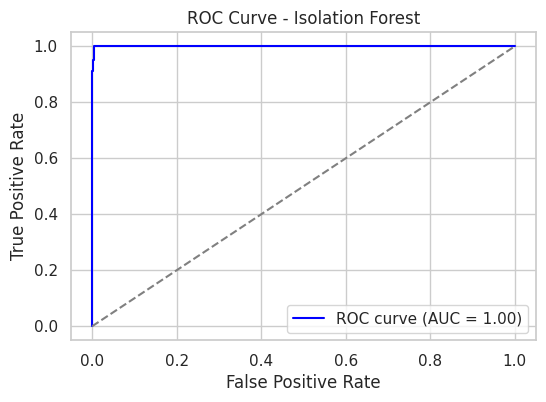

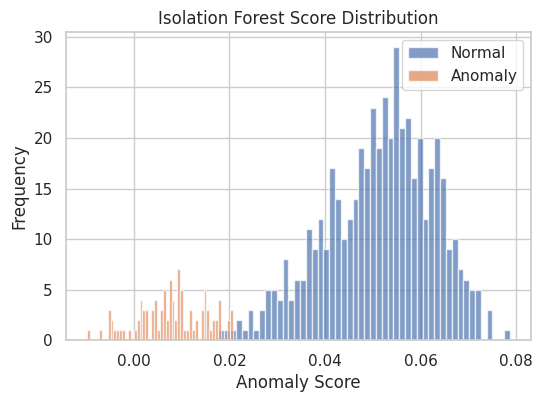

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------
# 1️⃣ Simulate large batch
# -------------------------
n_normal = 500
n_anomaly = 100

# Normal users (inliers)
normal_users = pd.DataFrame({
    'call_count_outgoing': np.random.randint(10, 50, n_normal),
    'call_count_incoming': np.random.randint(10, 50, n_normal),
    'avg_call_duration': np.random.uniform(2, 10, n_normal),
    'sms_count_sent': np.random.randint(5, 20, n_normal),
    'sms_count_received': np.random.randint(5, 20, n_normal),
    'avg_daily_usage': np.random.uniform(20, 50, n_normal),
    'usage_variance': np.random.uniform(1, 5, n_normal),
    'is_company_number': np.random.randint(0, 2, n_normal),
    'phone_prefix_freq': np.random.randint(50, 200, n_normal),
    'status': 'Active',
    'registered_location': np.random.choice(['Location_1', 'Location_2', 'Location_3'], n_normal),
    'current_location': np.random.choice(['Location_1', 'Location_2', 'Location_3'], n_normal)
})

# Anomalous users (outliers)
anomalous_users = pd.DataFrame({
    'call_count_outgoing': np.random.randint(0, 5, n_anomaly),
    'call_count_incoming': np.random.randint(0, 5, n_anomaly),
    'avg_call_duration': np.random.uniform(0, 1, n_anomaly),
    'sms_count_sent': np.random.randint(100, 1000, n_anomaly),
    'sms_count_received': np.random.randint(100, 1000, n_anomaly),
    'avg_daily_usage': np.random.uniform(300, 800, n_anomaly),
    'usage_variance': np.random.uniform(20, 100, n_anomaly),
    'is_company_number': np.zeros(n_anomaly),
    'phone_prefix_freq': np.random.randint(1, 5, n_anomaly),
    'status': 'Suspended',  # anomaly
    'registered_location': np.random.choice(['Location_4', 'Location_5'], n_anomaly),
    'current_location': np.random.choice(['Location_4', 'Location_5'], n_anomaly)
})

# Combine
batch = pd.concat([normal_users, anomalous_users], ignore_index=True)

# -------------------------
# 2️⃣ Add engineered features
# -------------------------
batch['total_calls'] = batch['call_count_outgoing'] + batch['call_count_incoming']
batch['call_ratio_out_in'] = batch['call_count_outgoing'] / (batch['call_count_incoming'] + 1)
batch['sms_ratio_sent_received'] = batch['sms_count_sent'] / (batch['sms_count_received'] + 1)
batch['high_call_volume'] = (batch['total_calls'] > X_raw['total_calls'].median()).astype(int)
batch['high_sms_volume'] = ((batch['sms_count_sent'] + batch['sms_count_received']) >
                           (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

# -------------------------
# 3️⃣ Preprocess
# -------------------------
batch_transformed = preprocessor.transform(batch)

# -------------------------
# 4️⃣ Predict anomalies
# -------------------------
y_pred_batch = iso.predict(batch_transformed)
scores_batch = iso.decision_function(batch_transformed)

# Map labels for ROC
y_true_batch = batch['status'].map(lambda x: 0 if x=='Active' else 1)

# -------------------------
# 5️⃣ Compute ROC curve & AUC
# -------------------------
fpr, tpr, thresholds = roc_curve(y_true_batch, -scores_batch)  # lower scores = anomalies
roc_auc_value = auc(fpr, tpr)
print("ROC-AUC for batch:", roc_auc_value)

# -------------------------
# 6️⃣ Plot ROC curve
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest')
plt.legend()
plt.show()

# -------------------------
# 7️⃣ Plot anomaly score distribution
# -------------------------
plt.figure(figsize=(6,4))
plt.hist(scores_batch[y_true_batch==0], bins=50, alpha=0.7, label='Normal')
plt.hist(scores_batch[y_true_batch==1], bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Score Distribution')
plt.legend()
plt.show()


**Testing the model**

In [ ]:
print(f"Number of estimators: {len(iso.estimators_)}")


Number of estimators: 100


In [ ]:
print(iso.estimators_[0])


ExtraTreeRegressor(max_depth=8, max_features=1, random_state=1952926171)


In [ ]:
sample = X_train_transformed[0:1]
prediction = iso.predict(sample)
print(f"Prediction for the first sample: {prediction}")

Prediction for the first sample: [1]


In [ ]:
iso.fit(X_train_transformed)


IsolationForest(contamination=0.05, random_state=42)

***1: Test on Real Dataset (Not Synthetic)**

In [ ]:
# All real data
X_test_real = X_raw.copy()
y_test_real = X_test_real['status'].map(lambda x: 0 if x=='Active' else 1)

# Engineer features (same as training)
X_test_real['total_calls'] = X_test_real['call_count_outgoing'] + X_test_real['call_count_incoming']
X_test_real['call_ratio_out_in'] = X_test_real['call_count_outgoing'] / (X_test_real['call_count_incoming'] + 1)
X_test_real['sms_ratio_sent_received'] = X_test_real['sms_count_sent'] / (X_test_real['sms_count_received'] + 1)
X_test_real['high_call_volume'] = (X_test_real['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_test_real['high_sms_volume'] = ((X_test_real['sms_count_sent'] + X_test_real['sms_count_received']) >
                                  (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)


In [ ]:
X_test_real_transformed = preprocessor.transform(X_test_real)


In [ ]:
y_pred_real = iso.predict(X_test_real_transformed)
scores_real = iso.decision_function(X_test_real_transformed)


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_real, -scores_real)  # lower scores = anomalies
roc_auc_value = auc(fpr, tpr)
print("ROC-AUC on real dataset:", roc_auc_value)


ROC-AUC on real dataset: 0.541798477865643


In [ ]:
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.05,
    max_features=10,   # control feature subsampling
    random_state=42
)


**ALL-IN-ONE ISOLATION FOREST WITH PHONE PREFIX**

ROC-AUC on real dataset: 0.5044718798901128


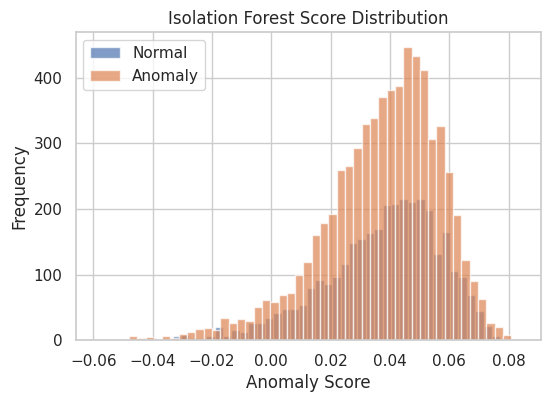

Dummy user prediction: Normal, Score: 0.009589461624553264


In [ ]:
# -------------------------------
# ALL-IN-ONE ISOLATION FOREST WITH PHONE PREFIX
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 1️⃣ Feature Engineering
# -------------------------------
# Assume X_raw is your dataset loaded already
# Compute phone_prefix_freq if not already present
if 'phone_prefix_freq' not in X_raw.columns:
    X_raw['phone_prefix_freq'] = X_raw.groupby('phone_prefix')['phone_prefix'].transform('count')

# Behavioral features
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)
X_raw['high_call_volume'] = (X_raw['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_raw['high_sms_volume'] = ((X_raw['sms_count_sent'] + X_raw['sms_count_received']) >
                            (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

# Features
numerical_features = [
    'call_count_outgoing','call_count_incoming','avg_call_duration','sms_count_sent',
    'sms_count_received','avg_daily_usage','usage_variance','is_company_number',
    'total_calls','call_ratio_out_in','sms_ratio_sent_received','high_call_volume',
    'high_sms_volume','phone_prefix_freq'
]

categorical_features = ['registered_location','current_location']  # small cardinality

# -------------------------------
# 2️⃣ Preprocessing
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Train only on Active users
X_train_normal = X_raw[X_raw['status']=='Active'].copy()
X_train_transformed = preprocessor.fit_transform(X_train_normal)

# Transform full dataset for evaluation
X_test_transformed = preprocessor.transform(X_raw)
y_test = X_raw['status'].map(lambda x: 0 if x=='Active' else 1)  # 0=normal, 1=anomaly

# -------------------------------
# 3️⃣ Train Isolation Forest
# -------------------------------
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.05,
    max_features=0.8,
    random_state=42
)
iso.fit(X_train_transformed)

# -------------------------------
# 4️⃣ Predict & Score
# -------------------------------
y_pred = iso.predict(X_test_transformed)
scores = iso.decision_function(X_test_transformed)

# -------------------------------
# 5️⃣ ROC-AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, -scores)  # lower score = anomaly
roc_auc_value = auc(fpr, tpr)
print("ROC-AUC on real dataset:", roc_auc_value)

# -------------------------------
# 6️⃣ Plot Anomaly Score Distribution
# -------------------------------
plt.figure(figsize=(6,4))
plt.hist(scores[y_test==0], bins=50, alpha=0.7, label='Normal')
plt.hist(scores[y_test==1], bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Score Distribution')
plt.legend()
plt.show()

# -------------------------------
# 7️⃣ Test Dummy User
# -------------------------------
dummy_user = pd.DataFrame({
    'call_count_outgoing':[0],
    'call_count_incoming':[0],
    'avg_call_duration':[0],
    'sms_count_sent':[500],
    'sms_count_received':[500],
    'avg_daily_usage':[400],
    'usage_variance':[50],
    'is_company_number':[0],
    'phone_prefix_freq':[1],  # rare prefix
    'registered_location':['Location_5'],
    'current_location':['Location_5'],
    'status':['Suspended']
})

dummy_user['total_calls'] = dummy_user['call_count_outgoing'] + dummy_user['call_count_incoming']
dummy_user['call_ratio_out_in'] = dummy_user['call_count_outgoing'] / (dummy_user['call_count_incoming'] + 1)
dummy_user['sms_ratio_sent_received'] = dummy_user['sms_count_sent'] / (dummy_user['sms_count_received'] + 1)
dummy_user['high_call_volume'] = (dummy_user['total_calls'] > X_raw['total_calls'].median()).astype(int)
dummy_user['high_sms_volume'] = ((dummy_user['sms_count_sent'] + dummy_user['sms_count_received']) >
                                 (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

dummy_transformed = preprocessor.transform(dummy_user)
pred = iso.predict(dummy_transformed)
score = iso.decision_function(dummy_transformed)
print(f"Dummy user prediction: {'Normal' if pred[0]==1 else 'Anomaly'}, Score: {score[0]}")


**improved (1)**

ROC-AUC on real dataset: 0.5291053522186572


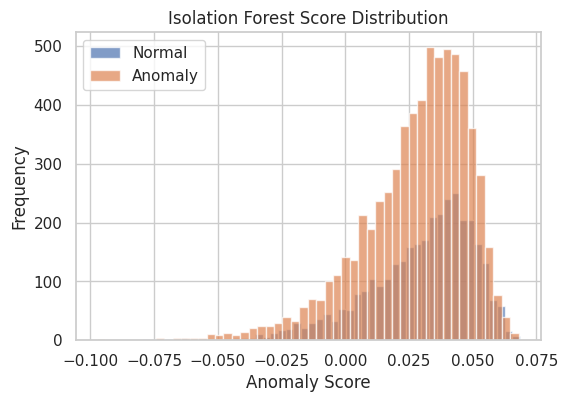

Dummy user prediction: Anomaly, Score: -0.07484111021298917


In [ ]:
# -------------------------------
# IMPROVED ISOLATION FOREST WITH FEATURE ENGINEERING
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 1️⃣ Feature Engineering
# -------------------------------
# Assume X_raw is your dataset already loaded

# Phone prefix score: rare prefixes get higher anomaly impact
prefix_counts = X_raw['phone_prefix'].value_counts()
X_raw['phone_prefix_score'] = X_raw['phone_prefix'].map(lambda x: 1 / prefix_counts[x])

# Behavioral features
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)
X_raw['high_call_volume'] = (X_raw['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_raw['high_sms_volume'] = ((X_raw['sms_count_sent'] + X_raw['sms_count_received']) >
                            (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)

# Interaction features
X_raw['calls_times_sms'] = X_raw['total_calls'] * (X_raw['sms_count_sent'] + X_raw['sms_count_received'])
X_raw['usage_ratio'] = X_raw['avg_daily_usage'] / (X_raw['avg_call_duration'] + 1)

# Numerical & categorical features
numerical_features = [
    'call_count_outgoing','call_count_incoming','avg_call_duration','sms_count_sent',
    'sms_count_received','avg_daily_usage','usage_variance','is_company_number',
    'total_calls','call_ratio_out_in','sms_ratio_sent_received','high_call_volume',
    'high_sms_volume','calls_times_sms','usage_ratio','phone_prefix_score'
]

categorical_features = ['registered_location','current_location']

# -------------------------------
# 2️⃣ Preprocessing
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Train only on Active users
X_train_normal = X_raw[X_raw['status']=='Active'].copy()
X_train_transformed = preprocessor.fit_transform(X_train_normal)

# Transform full dataset for evaluation
X_test_transformed = preprocessor.transform(X_raw)
y_test = X_raw['status'].map(lambda x: 0 if x=='Active' else 1)  # 0=normal, 1=anomaly

# -------------------------------
# 3️⃣ Train Isolation Forest with improved parameters
# -------------------------------
iso = IsolationForest(
    n_estimators=500,
    max_samples=0.9,
    contamination=0.1,
    max_features=0.9,
    random_state=42
)
iso.fit(X_train_transformed)

# -------------------------------
# 4️⃣ Predict & Score
# -------------------------------
y_pred = iso.predict(X_test_transformed)
scores = iso.decision_function(X_test_transformed)

# -------------------------------
# 5️⃣ ROC-AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, -scores)  # lower score = anomaly
roc_auc_value = auc(fpr, tpr)
print("ROC-AUC on real dataset:", roc_auc_value)

# -------------------------------
# 6️⃣ Plot Anomaly Score Distribution
# -------------------------------
plt.figure(figsize=(6,4))
plt.hist(scores[y_test==0], bins=50, alpha=0.7, label='Normal')
plt.hist(scores[y_test==1], bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Score Distribution')
plt.legend()
plt.show()

# -------------------------------
# 7️⃣ Test Dummy User
# -------------------------------
dummy_user = pd.DataFrame({
    'call_count_outgoing':[0],
    'call_count_incoming':[0],
    'avg_call_duration':[0],
    'sms_count_sent':[500],
    'sms_count_received':[500],
    'avg_daily_usage':[400],
    'usage_variance':[50],
    'is_company_number':[0],
    'phone_prefix':[999],  # rare prefix
    'registered_location':['Location_5'],
    'current_location':['Location_5'],
    'status':['Suspended']
})

# Feature engineering for dummy user
dummy_user['phone_prefix_score'] = 1 / 1  # extremely rare prefix
dummy_user['total_calls'] = dummy_user['call_count_outgoing'] + dummy_user['call_count_incoming']
dummy_user['call_ratio_out_in'] = dummy_user['call_count_outgoing'] / (dummy_user['call_count_incoming'] + 1)
dummy_user['sms_ratio_sent_received'] = dummy_user['sms_count_sent'] / (dummy_user['sms_count_received'] + 1)
dummy_user['high_call_volume'] = (dummy_user['total_calls'] > X_raw['total_calls'].median()).astype(int)
dummy_user['high_sms_volume'] = ((dummy_user['sms_count_sent'] + dummy_user['sms_count_received']) >
                                 (X_raw['sms_count_sent'] + X_raw['sms_count_received']).median()).astype(int)
dummy_user['calls_times_sms'] = dummy_user['total_calls'] * (dummy_user['sms_count_sent'] + dummy_user['sms_count_received'])
dummy_user['usage_ratio'] = dummy_user['avg_daily_usage'] / (dummy_user['avg_call_duration'] + 1)

dummy_transformed = preprocessor.transform(dummy_user)
pred = iso.predict(dummy_transformed)
score = iso.decision_function(dummy_transformed)
print(f"Dummy user prediction: {'Normal' if pred[0]==1 else 'Anomaly'}, Score: {score[0]}")


**improved (2)**

ROC-AUC on real dataset: 0.5072518288161231


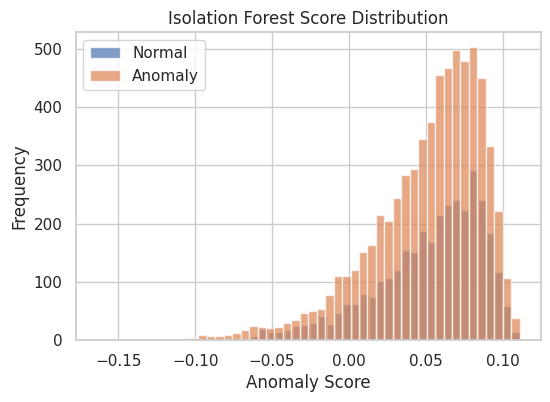

Dummy user prediction: Anomaly, Score: -0.21807715015708662


In [ ]:
# -------------------------------
# STABLE ISOLATION FOREST PIPELINE
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 1️⃣ Feature Engineering
# -------------------------------
# Assume X_raw is your dataset already loaded

# Phone prefix frequency score (rare = high score)
prefix_counts = X_raw['phone_prefix'].value_counts()
X_raw['phone_prefix_score'] = X_raw['phone_prefix'].map(lambda x: 1 / prefix_counts[x])

# Total calls & SMS
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['total_sms'] = X_raw['sms_count_sent'] + X_raw['sms_count_received']

# Behavioral ratios
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)

# Interaction features
X_raw['calls_times_sms'] = X_raw['total_calls'] * X_raw['total_sms']
X_raw['usage_ratio'] = X_raw['avg_daily_usage'] / (X_raw['avg_call_duration'] + 1)

# -------------------------------
# 2️⃣ Define numeric features
# -------------------------------
numeric_features = [
    'call_count_outgoing','call_count_incoming','avg_call_duration',
    'sms_count_sent','sms_count_received','avg_daily_usage','usage_variance',
    'is_company_number','total_calls','total_sms','call_ratio_out_in',
    'sms_ratio_sent_received','calls_times_sms','usage_ratio','phone_prefix_score'
]

# -------------------------------
# 3️⃣ Preprocessing: StandardScaler
# -------------------------------
scaler = StandardScaler()
X_raw_scaled = scaler.fit_transform(X_raw[numeric_features])

# -------------------------------
# 4️⃣ Train Isolation Forest
# -------------------------------
# Train only on Active users
X_train_scaled = scaler.transform(X_raw[X_raw['status']=='Active'][numeric_features])

iso = IsolationForest(
    n_estimators=500,
    max_samples=0.9,
    contamination=0.1,
    max_features=0.9,
    random_state=42
)
iso.fit(X_train_scaled)

# -------------------------------
# 5️⃣ Predict anomalies on full dataset
# -------------------------------
y_pred = iso.predict(X_raw_scaled)
scores = iso.decision_function(X_raw_scaled)

# Map status for ROC-AUC (0=normal, 1=anomaly)
y_true = X_raw['status'].map(lambda x: 0 if x=='Active' else 1)

# -------------------------------
# 6️⃣ ROC-AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_true, -scores)  # lower score = anomaly
roc_auc_value = auc(fpr, tpr)
print("ROC-AUC on real dataset:", roc_auc_value)

# -------------------------------
# 7️⃣ Plot anomaly score distribution
# -------------------------------
plt.figure(figsize=(6,4))
plt.hist(scores[y_true==0], bins=50, alpha=0.7, label='Normal')
plt.hist(scores[y_true==1], bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Score Distribution')
plt.legend()
plt.show()

# -------------------------------
# 8️⃣ Test Dummy User
# -------------------------------
dummy_user = pd.DataFrame({
    'call_count_outgoing':[0],
    'call_count_incoming':[0],
    'avg_call_duration':[0],
    'sms_count_sent':[500],
    'sms_count_received':[500],
    'avg_daily_usage':[400],
    'usage_variance':[50],
    'is_company_number':[0],
    'phone_prefix':[999],
    'status':['Suspended']
})

# Feature engineering for dummy user
dummy_user['phone_prefix_score'] = 1 / 1
dummy_user['total_calls'] = dummy_user['call_count_outgoing'] + dummy_user['call_count_incoming']
dummy_user['total_sms'] = dummy_user['sms_count_sent'] + dummy_user['sms_count_received']
dummy_user['call_ratio_out_in'] = dummy_user['call_count_outgoing'] / (dummy_user['call_count_incoming'] + 1)
dummy_user['sms_ratio_sent_received'] = dummy_user['sms_count_sent'] / (dummy_user['sms_count_received'] + 1)
dummy_user['calls_times_sms'] = dummy_user['total_calls'] * dummy_user['total_sms']
dummy_user['usage_ratio'] = dummy_user['avg_daily_usage'] / (dummy_user['avg_call_duration'] + 1)

# Scale features
dummy_scaled = scaler.transform(dummy_user[numeric_features])
pred = iso.predict(dummy_scaled)
score = iso.decision_function(dummy_scaled)
print(f"Dummy user prediction: {'Normal' if pred[0]==1 else 'Anomaly'}, Score: {score[0]}")


ROC-AUC on real dataset: 0.5078614639934811


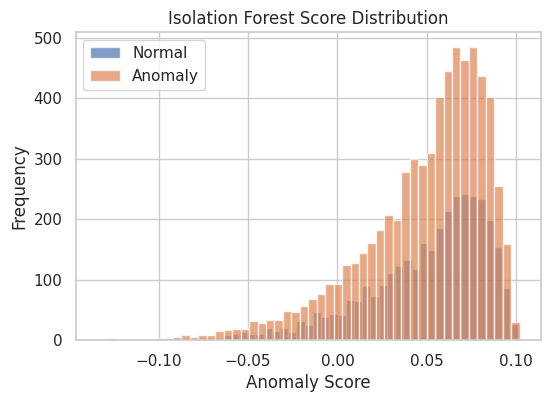

Dummy user prediction: Anomaly, Score: -0.1814273472757429


In [ ]:
# -------------------------------
# IMPROVED ISOLATION FOREST PIPELINE
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 1️⃣ Feature Engineering
# -------------------------------
X_raw['phone_prefix_score'] = X_raw['phone_prefix'].map(lambda x: 1 / X_raw['phone_prefix'].value_counts()[x])

# Total calls & SMS
X_raw['total_calls'] = X_raw['call_count_outgoing'] + X_raw['call_count_incoming']
X_raw['total_sms'] = X_raw['sms_count_sent'] + X_raw['sms_count_received']

# Log-transform extreme features
X_raw['sms_count_sent_log'] = np.log1p(X_raw['sms_count_sent'])
X_raw['sms_count_received_log'] = np.log1p(X_raw['sms_count_received'])
X_raw['avg_daily_usage_log'] = np.log1p(X_raw['avg_daily_usage'])

# Behavioral ratios
X_raw['call_ratio_out_in'] = X_raw['call_count_outgoing'] / (X_raw['call_count_incoming'] + 1)
X_raw['sms_ratio_sent_received'] = X_raw['sms_count_sent'] / (X_raw['sms_count_received'] + 1)

# Interaction features
X_raw['calls_times_sms'] = X_raw['total_calls'] * X_raw['total_sms']
X_raw['usage_ratio'] = X_raw['avg_daily_usage'] / (X_raw['avg_call_duration'] + 1)

# High/low volume flags
X_raw['high_call_volume'] = (X_raw['total_calls'] > X_raw['total_calls'].median()).astype(int)
X_raw['high_sms_volume'] = (X_raw['total_sms'] > X_raw['total_sms'].median()).astype(int)

# -------------------------------
# 2️⃣ Numeric features
# -------------------------------
numeric_features = [
    'call_count_outgoing','call_count_incoming','avg_call_duration',
    'sms_count_sent_log','sms_count_received_log','avg_daily_usage_log',
    'usage_variance','is_company_number','total_calls','total_sms',
    'call_ratio_out_in','sms_ratio_sent_received','calls_times_sms',
    'usage_ratio','phone_prefix_score','high_call_volume','high_sms_volume'
]

# -------------------------------
# 3️⃣ Scaling
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw[numeric_features])
X_train_scaled = scaler.transform(X_raw[X_raw['status']=='Active'][numeric_features])

# -------------------------------
# 4️⃣ Train Isolation Forest
# -------------------------------
iso = IsolationForest(
    n_estimators=1000,
    max_samples=0.9,
    contamination=0.1,
    max_features=1.0,
    random_state=42
)
iso.fit(X_train_scaled)

# -------------------------------
# 5️⃣ Predict & ROC-AUC
# -------------------------------
y_true = X_raw['status'].map(lambda x: 0 if x=='Active' else 1)
scores = iso.decision_function(X_scaled)

fpr, tpr, thresholds = roc_curve(y_true, -scores)
roc_auc_value = auc(fpr, tpr)
print("ROC-AUC on real dataset:", roc_auc_value)

# -------------------------------
# 6️⃣ Plot scores
# -------------------------------
plt.figure(figsize=(6,4))
plt.hist(scores[y_true==0], bins=50, alpha=0.7, label='Normal')
plt.hist(scores[y_true==1], bins=50, alpha=0.7, label='Anomaly')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Score Distribution')
plt.legend()
plt.show()

# -------------------------------
# 7️⃣ Test Dummy User
# -------------------------------
dummy_user = pd.DataFrame({
    'call_count_outgoing':[0],
    'call_count_incoming':[0],
    'avg_call_duration':[0],
    'sms_count_sent':[500],
    'sms_count_received':[500],
    'avg_daily_usage':[400],
    'usage_variance':[50],
    'is_company_number':[0],
    'phone_prefix':[999],
    'status':['Suspended']
})

# Feature engineering for dummy
dummy_user['phone_prefix_score'] = 1 / 1
dummy_user['total_calls'] = dummy_user['call_count_outgoing'] + dummy_user['call_count_incoming']
dummy_user['total_sms'] = dummy_user['sms_count_sent'] + dummy_user['sms_count_received']
dummy_user['sms_count_sent_log'] = np.log1p(dummy_user['sms_count_sent'])
dummy_user['sms_count_received_log'] = np.log1p(dummy_user['sms_count_received'])
dummy_user['avg_daily_usage_log'] = np.log1p(dummy_user['avg_daily_usage'])
dummy_user['call_ratio_out_in'] = dummy_user['call_count_outgoing'] / (dummy_user['call_count_incoming'] + 1)
dummy_user['sms_ratio_sent_received'] = dummy_user['sms_count_sent'] / (dummy_user['sms_count_received'] + 1)
dummy_user['calls_times_sms'] = dummy_user['total_calls'] * dummy_user['total_sms']
dummy_user['usage_ratio'] = dummy_user['avg_daily_usage'] / (dummy_user['avg_call_duration'] + 1)
dummy_user['high_call_volume'] = 1
dummy_user['high_sms_volume'] = 1

# Scale and predict
dummy_scaled = scaler.transform(dummy_user[numeric_features])
pred = iso.predict(dummy_scaled)
score = iso.decision_function(dummy_scaled)
print(f"Dummy user prediction: {'Normal' if pred[0]==1 else 'Anomaly'}, Score: {score[0]}")


In [ ]:
import joblib

# 1️⃣ Save the trained Isolation Forest model
joblib.dump(iso, "isolation_forest_model.pkl")
print("Isolation Forest model saved!")

# 2️⃣ Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved!")


Isolation Forest model saved!
Scaler saved!


In [ ]:
# after training: e.g. `model` is your trained IsolationForest
from joblib import dump
dump(model, '/content/model.joblib')   # saves to Colab VM


['/content/model.joblib']

In [ ]:
import joblib
joblib.dump(model, "isolation_forest.pkl")


['isolation_forest.pkl']